# Deep Learning with TensorFlow/Keras

Now that we have completed a project of Machine Learning with spark ML, in this assignment, we will be swithing to the context of Deep Learning with Tensorflow/Keras by two tasks:
- Task1: Image Classification with CNN
- Task2: Image captioning with a combination of CNN and RNN

## Task 1: Going Deeper with convolutions


Before **Inception v1** (**GoogLeNet**), which is the winner of the **ILSVRC** (ImageNet Large Scale Visual Recognition Competition) in 2014, most popular CNNs just stacked convolution layers deeper and deeper, hoping to get better performance.
The Inception network, however, uses a lot of tricks to improve performance in terms of speed and accuracy.
Compared to other networks, **Inception v1** has significant improvement over **ZFNet** (the winner in 2013) and **AlexNet** (the winner in 2012), and has relatively lower error rate compared with the VGGNet.

In this task, we will be implementing the inception architecture [in this paper](https://arxiv.org/abs/1409.4842) with TensorFlow/Keras. 

The goal of this task is to understand how to write code to build the model, as long as you can verify the correctness of the code (e.g., through Keras model summary), it is not necessary to train the model.

References:



https://gist.github.com/joelouismarino/a2ede9ab3928f999575423b9887abd14#file-googlenet-py
           https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.4-tf


In [0]:
cifar10_dataset = tf.keras.datasets.cifar10

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10_dataset.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [0]:
print("shape of train x: ", x_train.shape)
print('shape of train y: ', y_train.shape)
print('shape of test x: ', x_test.shape)
print('shape of test y: ', y_test.shape)
print('type of train x: ', x_train.dtype)
print('type of train y: ', y_train.dtype)

shape of train x:  (50000, 32, 32, 3)
shape of train y:  (50000, 1)
shape of test x:  (10000, 32, 32, 3)
shape of test y:  (10000, 1)
type of train x:  uint8
type of train y:  uint8


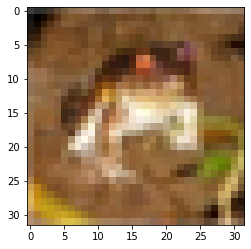

In [0]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0])
plt.show()

In [0]:
print('Before normalization: ')
print('\t min of train is {}, max of train is {}'.format(np.min(x_train), np.max(x_train)))
print('\t min of test is {}, max of train is {}'.format(np.min(x_test), np.max(x_test)))
x_train = x_train / 255
x_test = x_test / 255

print('After normalization:')
print('\t min of train is {}, max of train is {}'.format(np.min(x_train), np.max(x_train)))
print('\t min of test is {}, max of test is {}'.format(np.min(x_test), np.max(x_test)))

Before normalization: 
	 min of train is 0, max of train is 255
	 min of test is 0, max of train is 255
After normalization:
	 min of train is 0.0, max of train is 1.0
	 min of test is 0.0, max of test is 1.0


In [0]:
print(x_train[0])

[[[0.23137255 0.24313725 0.24705882]
  [0.16862745 0.18039216 0.17647059]
  [0.19607843 0.18823529 0.16862745]
  ...
  [0.61960784 0.51764706 0.42352941]
  [0.59607843 0.49019608 0.4       ]
  [0.58039216 0.48627451 0.40392157]]

 [[0.0627451  0.07843137 0.07843137]
  [0.         0.         0.        ]
  [0.07058824 0.03137255 0.        ]
  ...
  [0.48235294 0.34509804 0.21568627]
  [0.46666667 0.3254902  0.19607843]
  [0.47843137 0.34117647 0.22352941]]

 [[0.09803922 0.09411765 0.08235294]
  [0.0627451  0.02745098 0.        ]
  [0.19215686 0.10588235 0.03137255]
  ...
  [0.4627451  0.32941176 0.19607843]
  [0.47058824 0.32941176 0.19607843]
  [0.42745098 0.28627451 0.16470588]]

 ...

 [[0.81568627 0.66666667 0.37647059]
  [0.78823529 0.6        0.13333333]
  [0.77647059 0.63137255 0.10196078]
  ...
  [0.62745098 0.52156863 0.2745098 ]
  [0.21960784 0.12156863 0.02745098]
  [0.20784314 0.13333333 0.07843137]]

 [[0.70588235 0.54509804 0.37647059]
  [0.67843137 0.48235294 0.16470588]


In [0]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, Concatenate, Reshape, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD


## Build the Inception-v1 model

In [0]:
def inception(input_tensor, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, 
              Name = None):
    
    conv_1x1 = Conv2D(filters_1x1, (1,1), padding = 'same', activation = 'relu', name = (Name + '/conv_1x1'))(input_tensor)
    
    conv_3x3_reduce = Conv2D(filters_3x3_reduce, (1, 1), padding = 'same', activation = 'relu', name = (Name + '/conv_3x3_reduce'))(input_tensor)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding = 'same', activation = 'relu', name = (Name + '/conv_3x3'))(conv_3x3_reduce)
 
    conv_5x5_reduce = Conv2D(filters_5x5_reduce, (1, 1), padding = 'same', activation = 'relu', name = (Name + '/conv_5x5_reduce'))(input_tensor)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding = 'same', activation = 'relu', name = (Name + '/conv_5x5'))(conv_5x5_reduce)
    
    pool = MaxPooling2D((3, 3), strides = (1, 1), padding = 'same', name = (Name + '/pool'))(input_tensor)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding = 'same', activation = 'relu', name = (Name + '/pool_proj'))(pool)
    
    output = Concatenate(axis = 3, name = (Name + '_output'))([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    return output

In [0]:
#Input layer
input_layer = Input(shape = (224, 224, 3), name = 'input_layer')

#Stem module
conv1_7x7 = Conv2D(64, (7, 7), strides = (2, 2), padding = 'same', activation = 'relu', 
                   name = 'conv1_7x7/s2')(input_layer) 
pool1_3x3 = MaxPooling2D((3, 3), strides = (2, 2), padding = 'same', name = 'pool1/3x3_s2')(conv1_7x7)
conv2_3x3_reduce = Conv2D(64, (1, 1), padding = 'same', activation = 'relu', 
                          name = 'conv2/3x3_reduce')(pool1_3x3)
conv2_3x3 = Conv2D(192, (3, 3), padding = 'same', activation = 'relu', 
                   name = 'conv2/3x3')(conv2_3x3_reduce)
pool2_3x3 = MaxPooling2D((3, 3), strides = (2, 2), padding = 'same', name = 'pool2/3x3_s2')(conv2_3x3)

#Inception 3a & 3b
inception_3a = inception(pool2_3x3, filters_1x1 = 64, filters_3x3_reduce = 96, 
                         filters_3x3 = 128, filters_5x5_reduce = 16, filters_5x5 = 32, 
                         filters_pool_proj = 32, Name = 'incep_3a')
inception_3b = inception(inception_3a, filters_1x1 = 128, filters_3x3_reduce = 128, 
                         filters_3x3 = 192, filters_5x5_reduce = 32, filters_5x5 = 96, 
                         filters_pool_proj = 64, Name = 'incep_3b')

#max pool & inception 4a
pool3_3x3 = MaxPooling2D((3, 3), strides = (2, 2), padding = 'same', name = 'pool3/3x3_s2')(inception_3b)
inception_4a = inception(pool3_3x3, filters_1x1 = 192, filters_3x3_reduce = 96, 
                         filters_3x3 = 208, filters_5x5_reduce = 16, filters_5x5 = 48, 
                         filters_pool_proj = 64, Name = 'incep_4a')


#aux1 brach
aux1_ave_pool = AveragePooling2D((5, 5), strides = (3, 3), name = 'aux1/ave_pool')(inception_4a)
aux1_conv = Conv2D(128, (1, 1), padding = 'same', activation = 'relu', 
                    name = 'aux1/conv')(aux1_ave_pool)
aux1_flat = Flatten()(aux1_conv)
aux1_fc = Dense(1024, activation = 'relu', name = 'aux1/fc')(aux1_flat)
aux1_dropout = Dropout(rate = 0.7)(aux1_fc)
aux1_output = Dense(1000, activation = 'softmax', name = 'aux1/classifier')(aux1_dropout)

#inception 4b & 4c & 4d
inception_4b = inception(inception_4a, filters_1x1 = 160, filters_3x3_reduce = 112, 
                         filters_3x3 = 224, filters_5x5_reduce = 24, filters_5x5 = 64, 
                         filters_pool_proj = 64, Name = 'incep_4b')
inception_4c = inception(inception_4b, filters_1x1 = 128, filters_3x3_reduce = 128, 
                         filters_3x3 = 256, filters_5x5_reduce = 24, filters_5x5 = 64, 
                         filters_pool_proj = 64, Name = 'incep_4c')
inception_4d = inception(inception_4c, filters_1x1 = 112, filters_3x3_reduce = 144, 
                         filters_3x3 = 288, filters_5x5_reduce = 32, filters_5x5 = 64, 
                         filters_pool_proj = 64, Name = 'incep_4d')

#aux2 branch
aux2_ave_pool = AveragePooling2D((5, 5), strides = (3, 3), name = 'aux2/ave_pool')(inception_4d)
aux2_conv = Conv2D(128, (1, 1), padding = 'same', activation = 'relu', 
                    name = 'aux2/conv')(aux2_ave_pool)
aux2_flat = Flatten()(aux2_conv)
aux2_fc = Dense(1024, activation = 'relu', name = 'aux2/fc')(aux2_flat)
aux2_dropout = Dropout(rate = 0.7)(aux2_fc)
aux2_output = Dense(1000, activation = 'softmax', name = 'aux2/classifier')(aux2_dropout)

#inception 4e & max pool
inception_4e = inception(inception_4d, filters_1x1 = 256, filters_3x3_reduce = 160, 
                         filters_3x3 = 320, filters_5x5_reduce = 32, filters_5x5 = 128, 
                         filters_pool_proj = 128, Name = 'incep_4e')
pool4_3x3 = MaxPooling2D((3, 3), strides = (2, 2), padding = 'same', name = 'pool4/3x3_s2')(inception_4e)

#inception 5a & 5b
inception_5a = inception(pool4_3x3, filters_1x1 = 256, filters_3x3_reduce = 160, 
                         filters_3x3 = 320, filters_5x5_reduce = 32, filters_5x5 = 128, 
                         filters_pool_proj = 128, Name = 'incep_5a')

inception_5b = inception(inception_5a, filters_1x1 = 384, filters_3x3_reduce = 192, 
                         filters_3x3 = 384, filters_5x5_reduce = 48, filters_5x5 = 128, 
                         filters_pool_proj = 128, Name = 'incep_5b')

#main output
ave_pool = AveragePooling2D((7, 7), strides = (1, 1), name = 'ave_pool')(inception_5b)
flat = Flatten()(ave_pool)
dropout = Dropout(rate = 0.4)(flat)
output = Dense(1000, activation = 'softmax', name = 'classifier')(dropout)



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model = Model(input_layer, [output, aux1_output, aux2_output], name = 'Inception_V1')

#print model layers
model.summary()

#compile model
sgd = SGD(lr = 0.1, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, 
              loss = ["sparse_categorical_crossentropy", "sparse_categorical_crossentropy", "sparse_categorical_crossentropy"], 
              loss_weights = [1, 0.3, 0.3], metrics = ["accuracy"])



Model: "Inception_V1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_7x7/s2 (Conv2D)           (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
pool1/3x3_s2 (MaxPooling2D)     (None, 56, 56, 64)   0           conv1_7x7/s2[0][0]               
__________________________________________________________________________________________________
conv2/3x3_reduce (Conv2D)       (None, 56, 56, 64)   4160        pool1/3x3_s2[0][0]               
_______________________________________________________________________________________

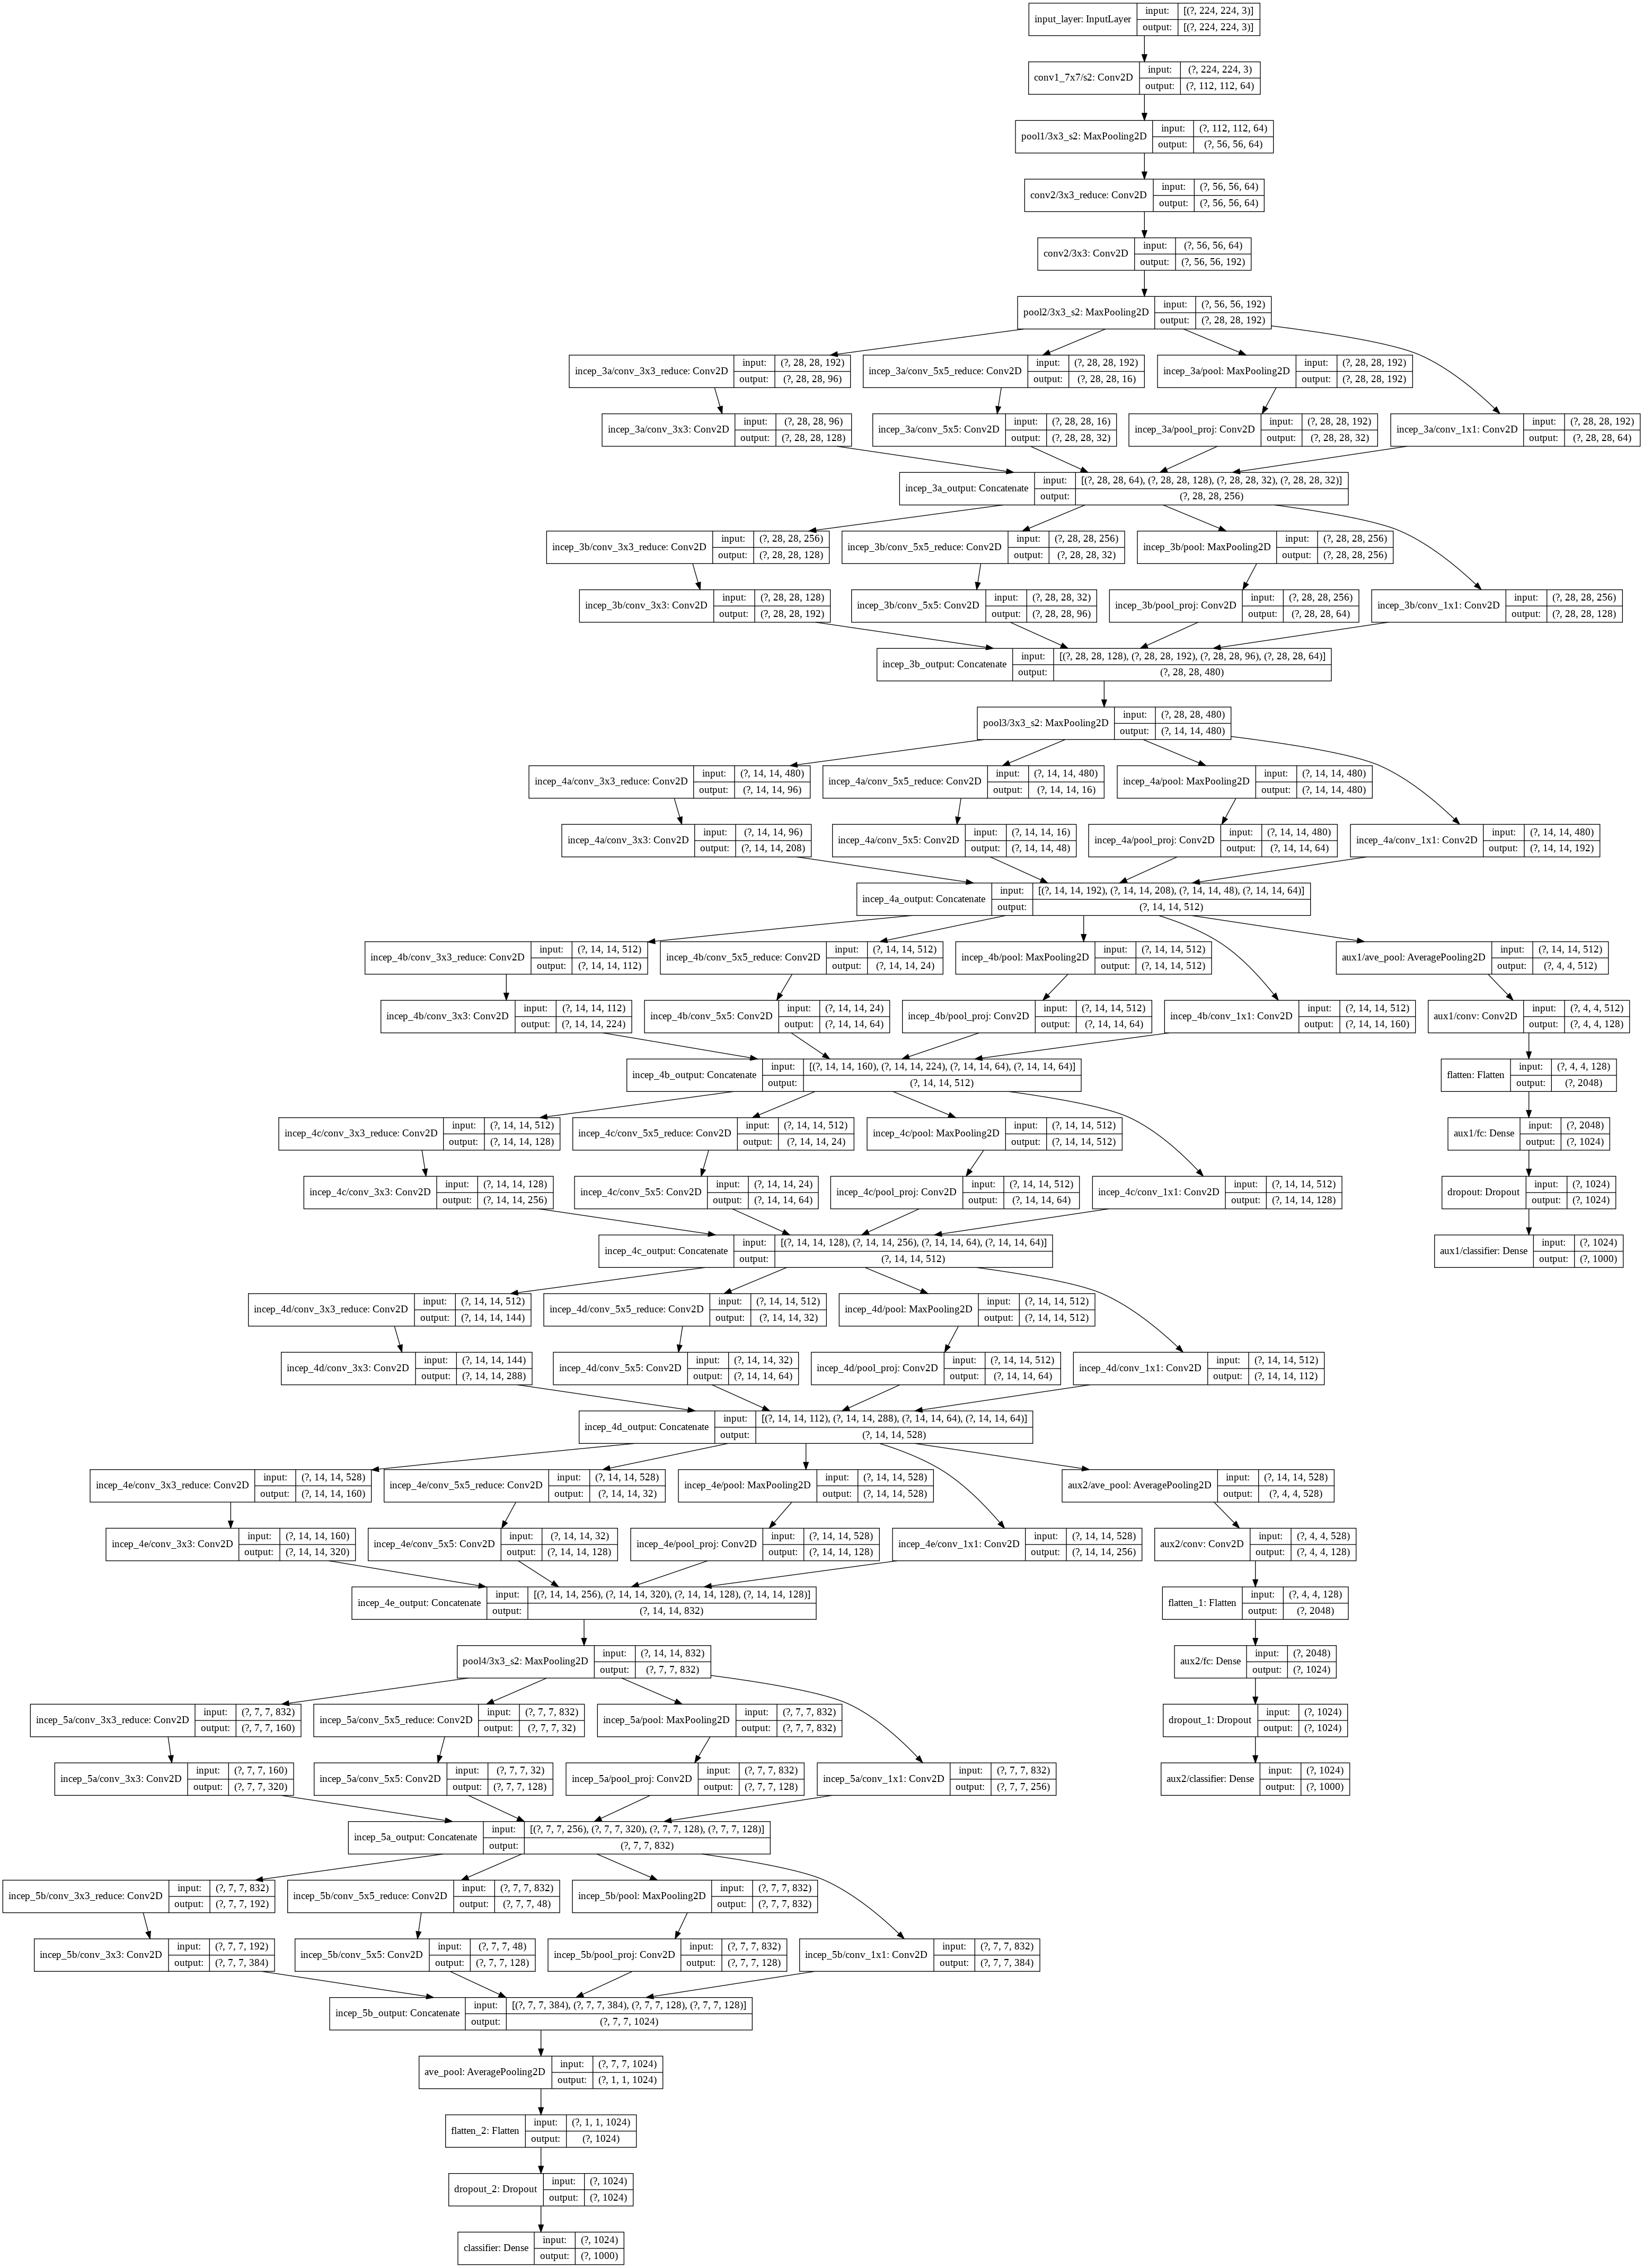

In [0]:
keras.utils.plot_model(model, 'inception_model.png', show_shapes = True)

## Task 2: Show and Tell: A Neural Image Caption Generator

Automatically describing the content of an image is a fundamental problem in AI that connects *computer vision* and *natural language processing*.
In this task, we will be looking into how we can use CNNs and RNNs to build an Image Caption Generator.

Specifically, you will be implementing and training the model [in this paper](https://arxiv.org/abs/1411.4555) with TensorFlow/Keras on one of the datasets mentioned in the paper.

To lighten the burden on training the network, you can use any pretrained network in [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

In [0]:
# code here